In [1]:
import pandas as pd
data = pd.read_csv("./data.csv")
data.head()

,Mois,Date de l'incident,Ligne,Lieu,Description de l'incident,Nombre de minutes de retard,Nombre de trains supprimés,Saison
0,septembre,2025-09-26,59,ANTWERPEN-ZUID,Intrusion dans les voies,1051,29,automne
1,septembre,2025-09-22,161,BOSVOORDE,Obstacle dans/à proximité de la voie,1588,74,automne
2,septembre,2025-09-17,161,MONT-SAINT-GUIBERT,Avarie matériel roulant,1083,37,automne
3,septembre,2025-09-15,60,DENDERMONDE,Dérangement à la signalisation,1288,12,automne
4,septembre,2025-09-11,50A,BEERNEM,Heurt d'une personne,3755,70,automne


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

## Causes générant le plus de retard et de suppression

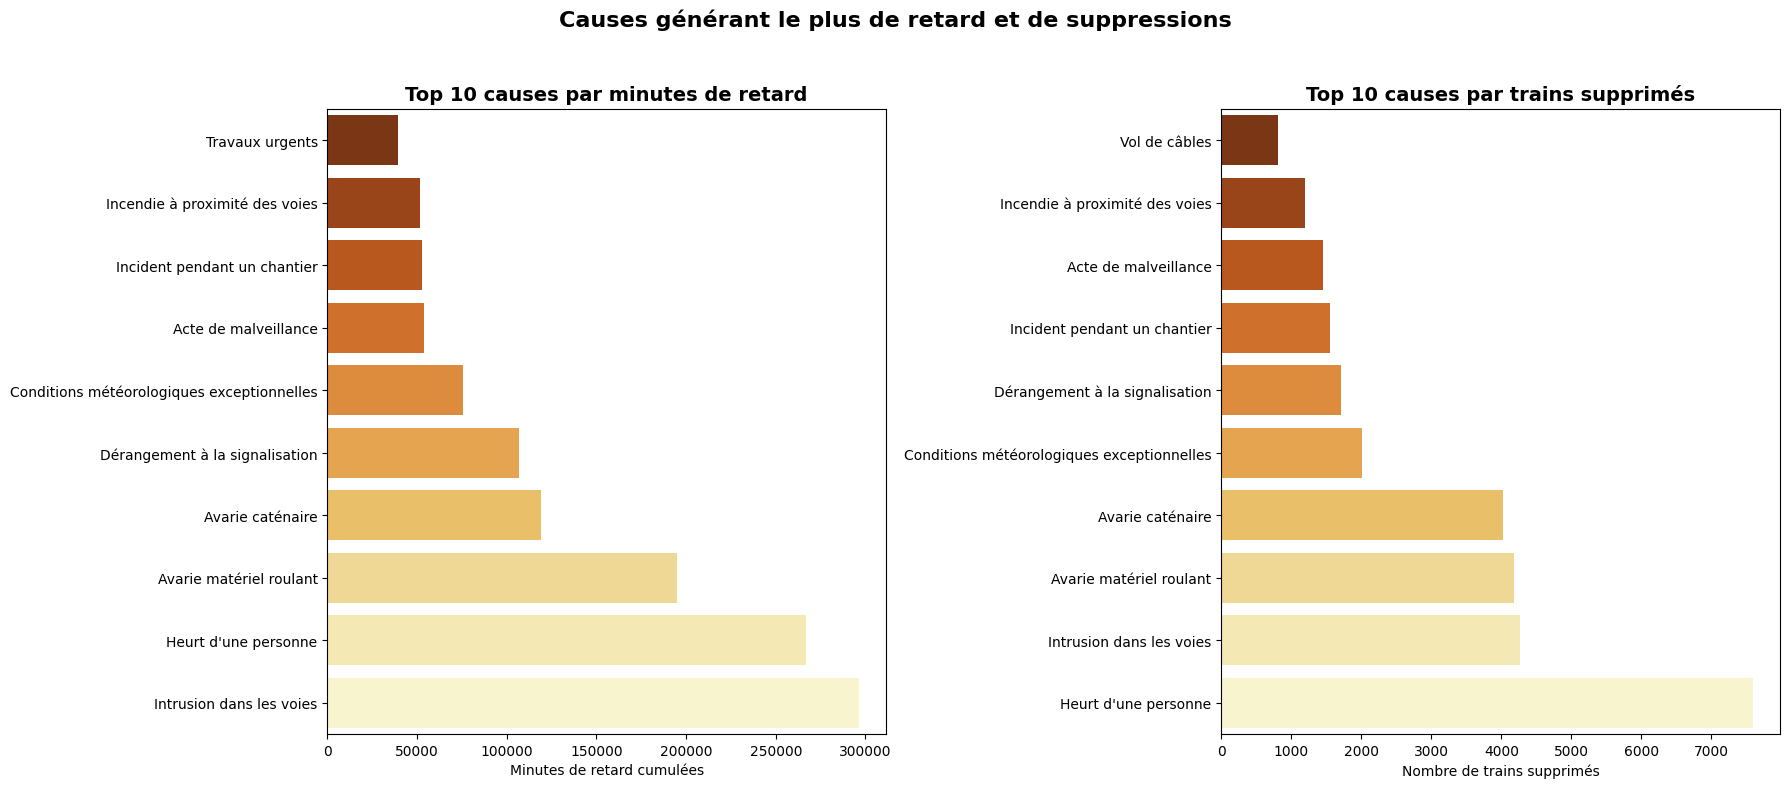

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Regrouper les indicateurs par cause
cause_kpi = data.groupby("Description de l'incident", as_index=False).agg({
    "Nombre de minutes de retard": "sum",
    "Nombre de trains supprimés": "sum",
})

# Trier et garder le Top 10 pour chaque indicateur
top10_retard = cause_kpi.nlargest(10, "Nombre de minutes de retard")
top10_suppr = cause_kpi.nlargest(10, "Nombre de trains supprimés")

# Créer 2 sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# --- Graphique 1 : Top 10 minutes de retard ---
sns.barplot(
    data=top10_retard,
    y="Description de l'incident", x="Nombre de minutes de retard",
    ax=axes[0], palette="YlOrBr", hue="Description de l'incident", legend=False
)
axes[0].set_title("Top 10 causes par minutes de retard", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Minutes de retard cumulées")
axes[0].set_ylabel("")
axes[0].invert_yaxis()  # Pour que la cause la plus importante soit en haut

# --- Graphique 2 : Top 10 suppressions ---
sns.barplot(
    data=top10_suppr,
    y="Description de l'incident", x="Nombre de trains supprimés",
    ax=axes[1], palette="YlOrBr", hue="Description de l'incident", legend=False
)
axes[1].set_title("Top 10 causes par trains supprimés", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Nombre de trains supprimés")
axes[1].set_ylabel("")
axes[1].invert_yaxis()

# --- Titre global ---
plt.suptitle("Causes générant le plus de retard et de suppressions", fontsize=16, fontweight="bold")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Causes les plus fréquentes par mois et par saison

In [10]:
def plot_cause_repartition_stacked_multi(df, time_col, title_prefix):
    """
    Affiche 3 graphiques stacked (empilés) côte à côte :
    - Nombre d'incidents
    - Minutes de retard cumulées
    - Trains supprimés
    """

    # --- Sécurité : aplatir les colonnes multi-index si nécessaire ---
    df.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

    # Vérification que les colonnes nécessaires existent
    expected_cols = [
        "Description de l'incident",
        "Nombre de minutes de retard",
        "Nombre de trains supprimés",
        time_col
    ]
    for col in expected_cols:
        if col not in df.columns:
            raise KeyError(f"Colonne manquante dans le DataFrame : '{col}'")

    # --- On garde uniquement les 10 causes principales ---
    top_causes = df["Description de l'incident"].value_counts().nlargest(10).index
    df_top = df[df["Description de l'incident"].isin(top_causes)]

    # --- Pivots pour chaque indicateur ---
    pivot_incidents = (
        df_top
        .groupby([time_col, "Description de l'incident"])
        .size()
        .unstack(fill_value=0)
    )

    pivot_retards = (
        df_top
        .pivot_table(index=time_col, columns="Description de l'incident",
                     values="Nombre de minutes de retard", aggfunc="sum", fill_value=0)
    )

    pivot_suppr = (
        df_top
        .pivot_table(index=time_col, columns="Description de l'incident",
                     values="Nombre de trains supprimés", aggfunc="sum", fill_value=0)
    )

    # --- Création des 3 graphiques empilés côte à côte ---
    fig, axes = plt.subplots(1, 3, figsize=(24, 16))

    pivot_incidents.plot(kind='bar', stacked=True, ax=axes[0], colormap='tab20', legend=False)
    axes[0].set_title(f"{title_prefix.capitalize()} - Nombre d'incidents", fontsize=13, fontweight='bold')
    axes[0].set_xlabel(title_prefix.capitalize())
    axes[0].set_ylabel("Nombre d'incidents")

    pivot_retards.plot(kind='bar', stacked=True, ax=axes[1], colormap='tab20', legend=False)
    axes[1].set_title(f"{title_prefix.capitalize()} - Minutes de retard cumulées", fontsize=13, fontweight='bold')
    axes[1].set_xlabel(title_prefix.capitalize())
    axes[1].set_ylabel("Minutes de retard cumulées")

    pivot_suppr.plot(kind='bar', stacked=True, ax=axes[2], colormap='tab20', legend=False)
    axes[2].set_title(f"{title_prefix.capitalize()} - Trains supprimés", fontsize=13, fontweight='bold')
    axes[2].set_xlabel(title_prefix.capitalize())
    axes[2].set_ylabel("Nombre de trains supprimés")

    # Légende commune
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Cause", bbox_to_anchor=(1.05, 0.9), loc='upper left')

    plt.suptitle(f"Répartition des causes ({title_prefix}) - Top 10", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    plt.show()

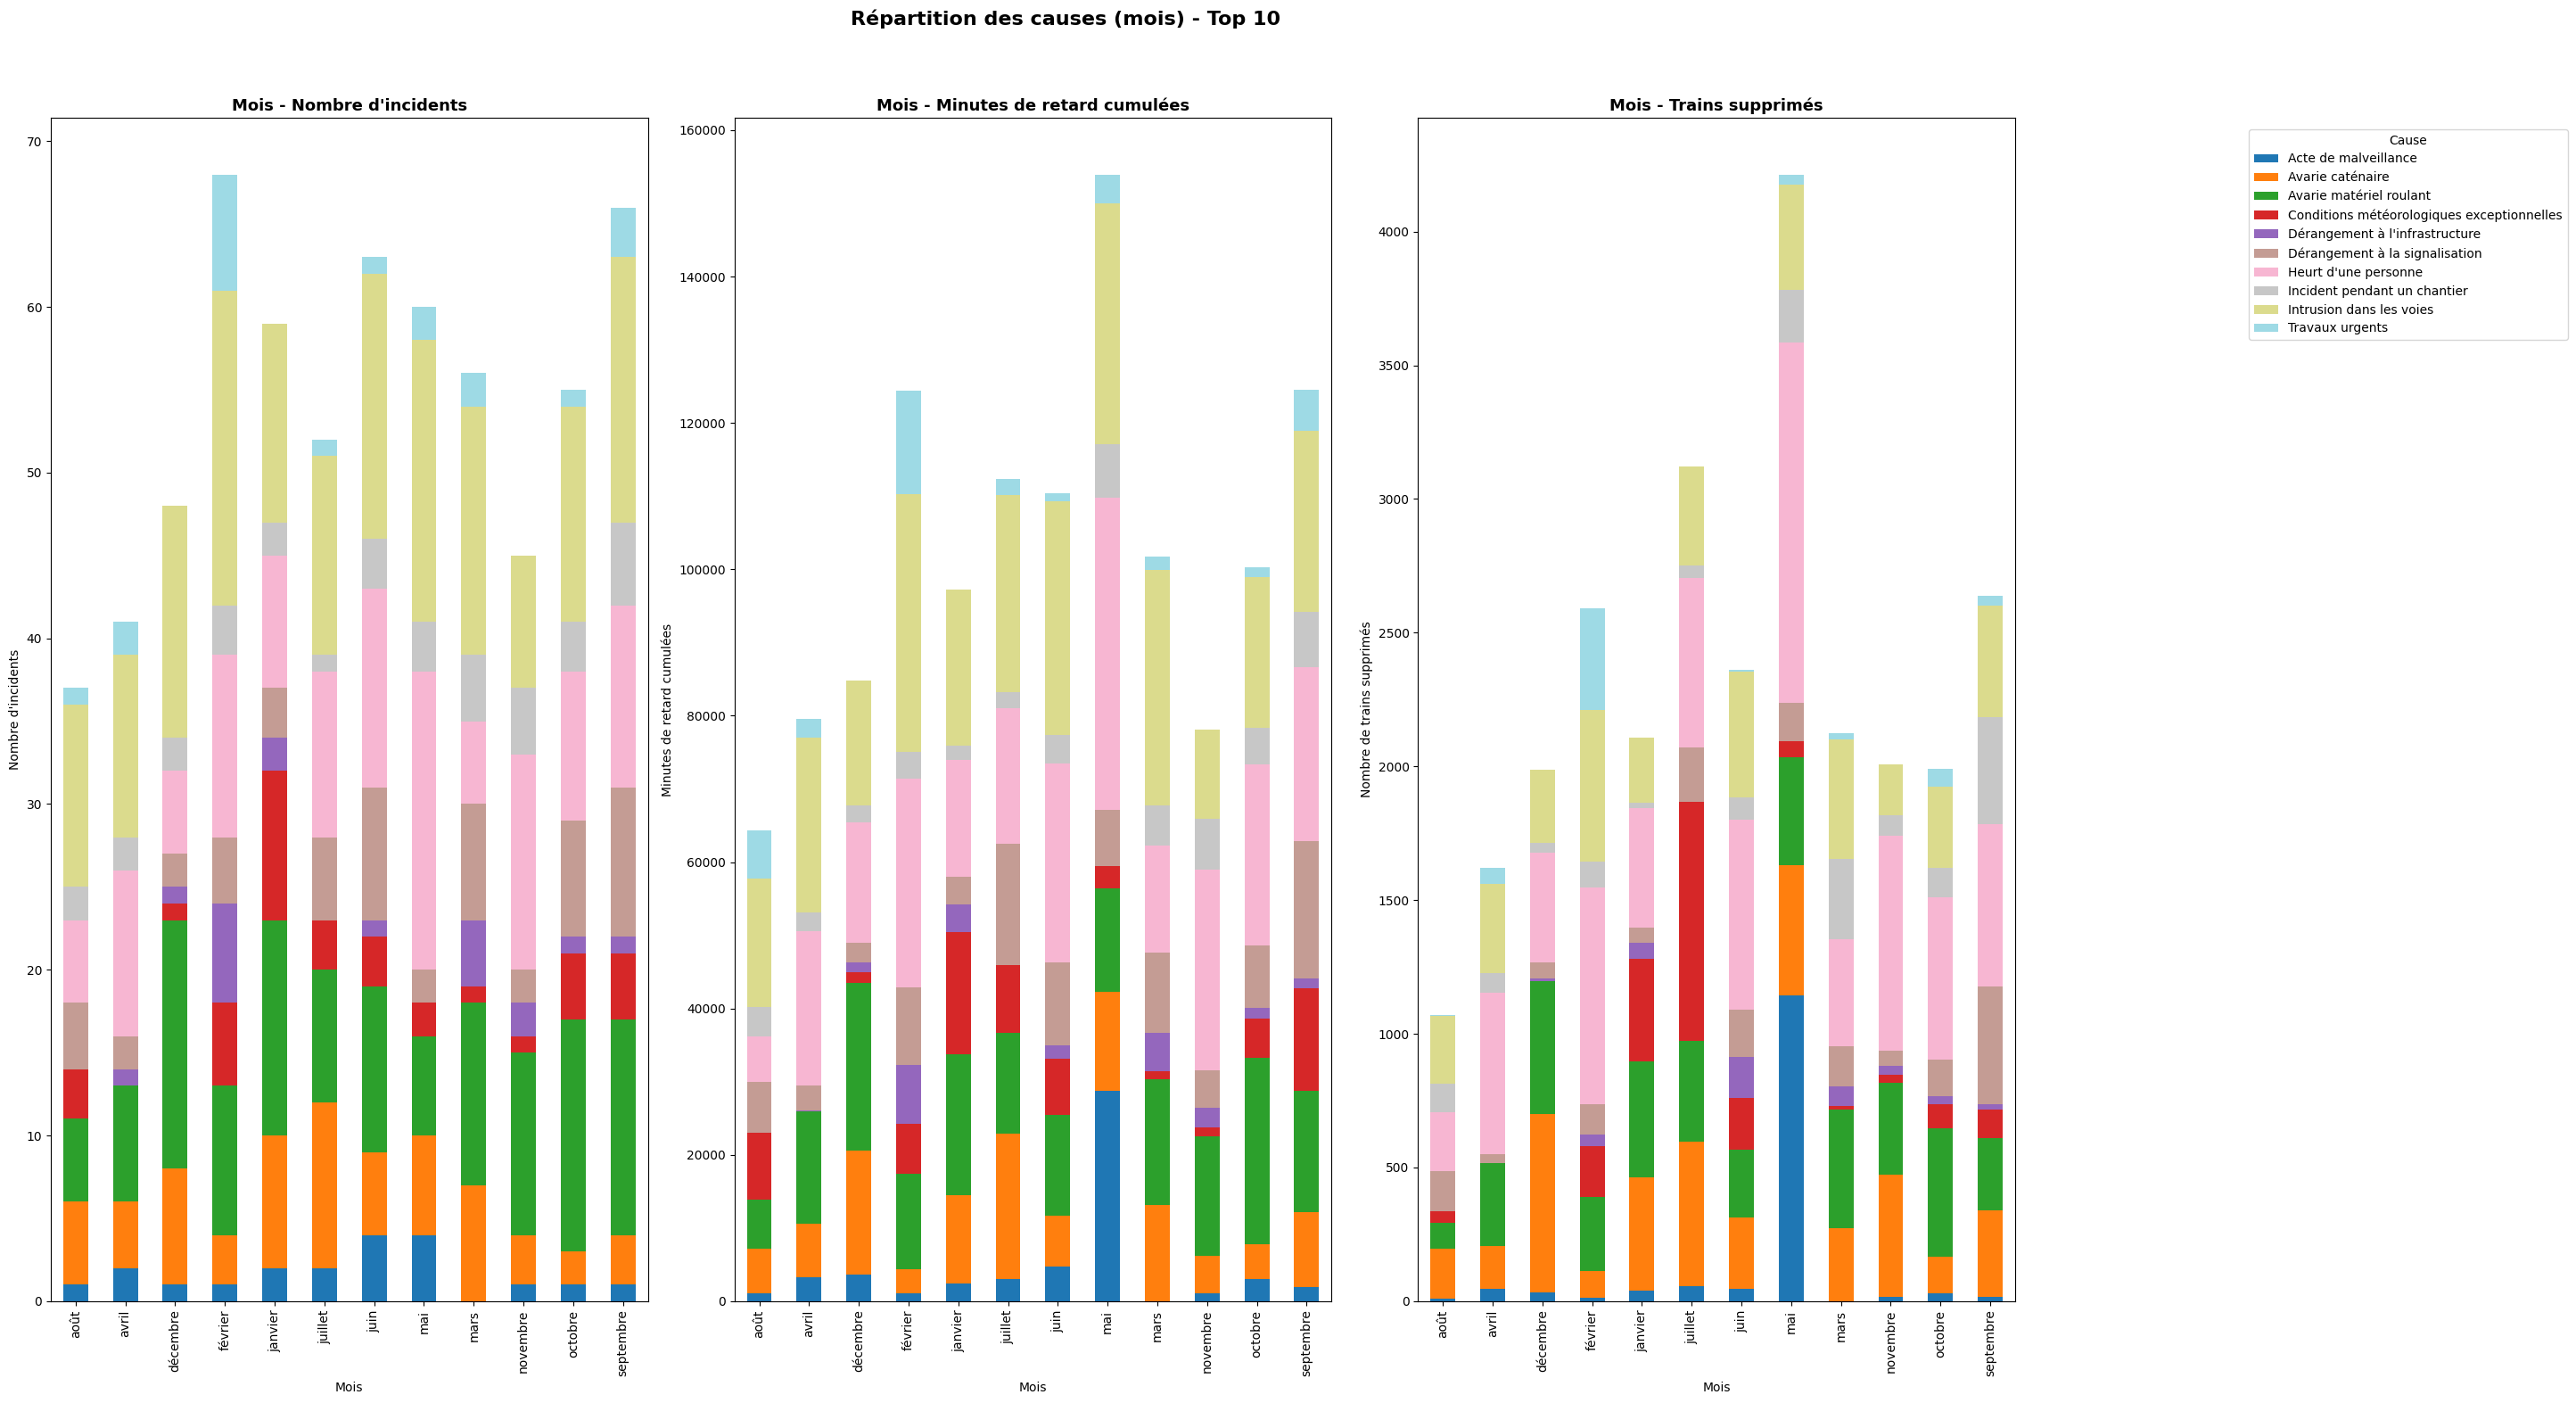

In [11]:
# Vue mensuelle
plot_cause_repartition_stacked_multi(data, "Mois", "mois")

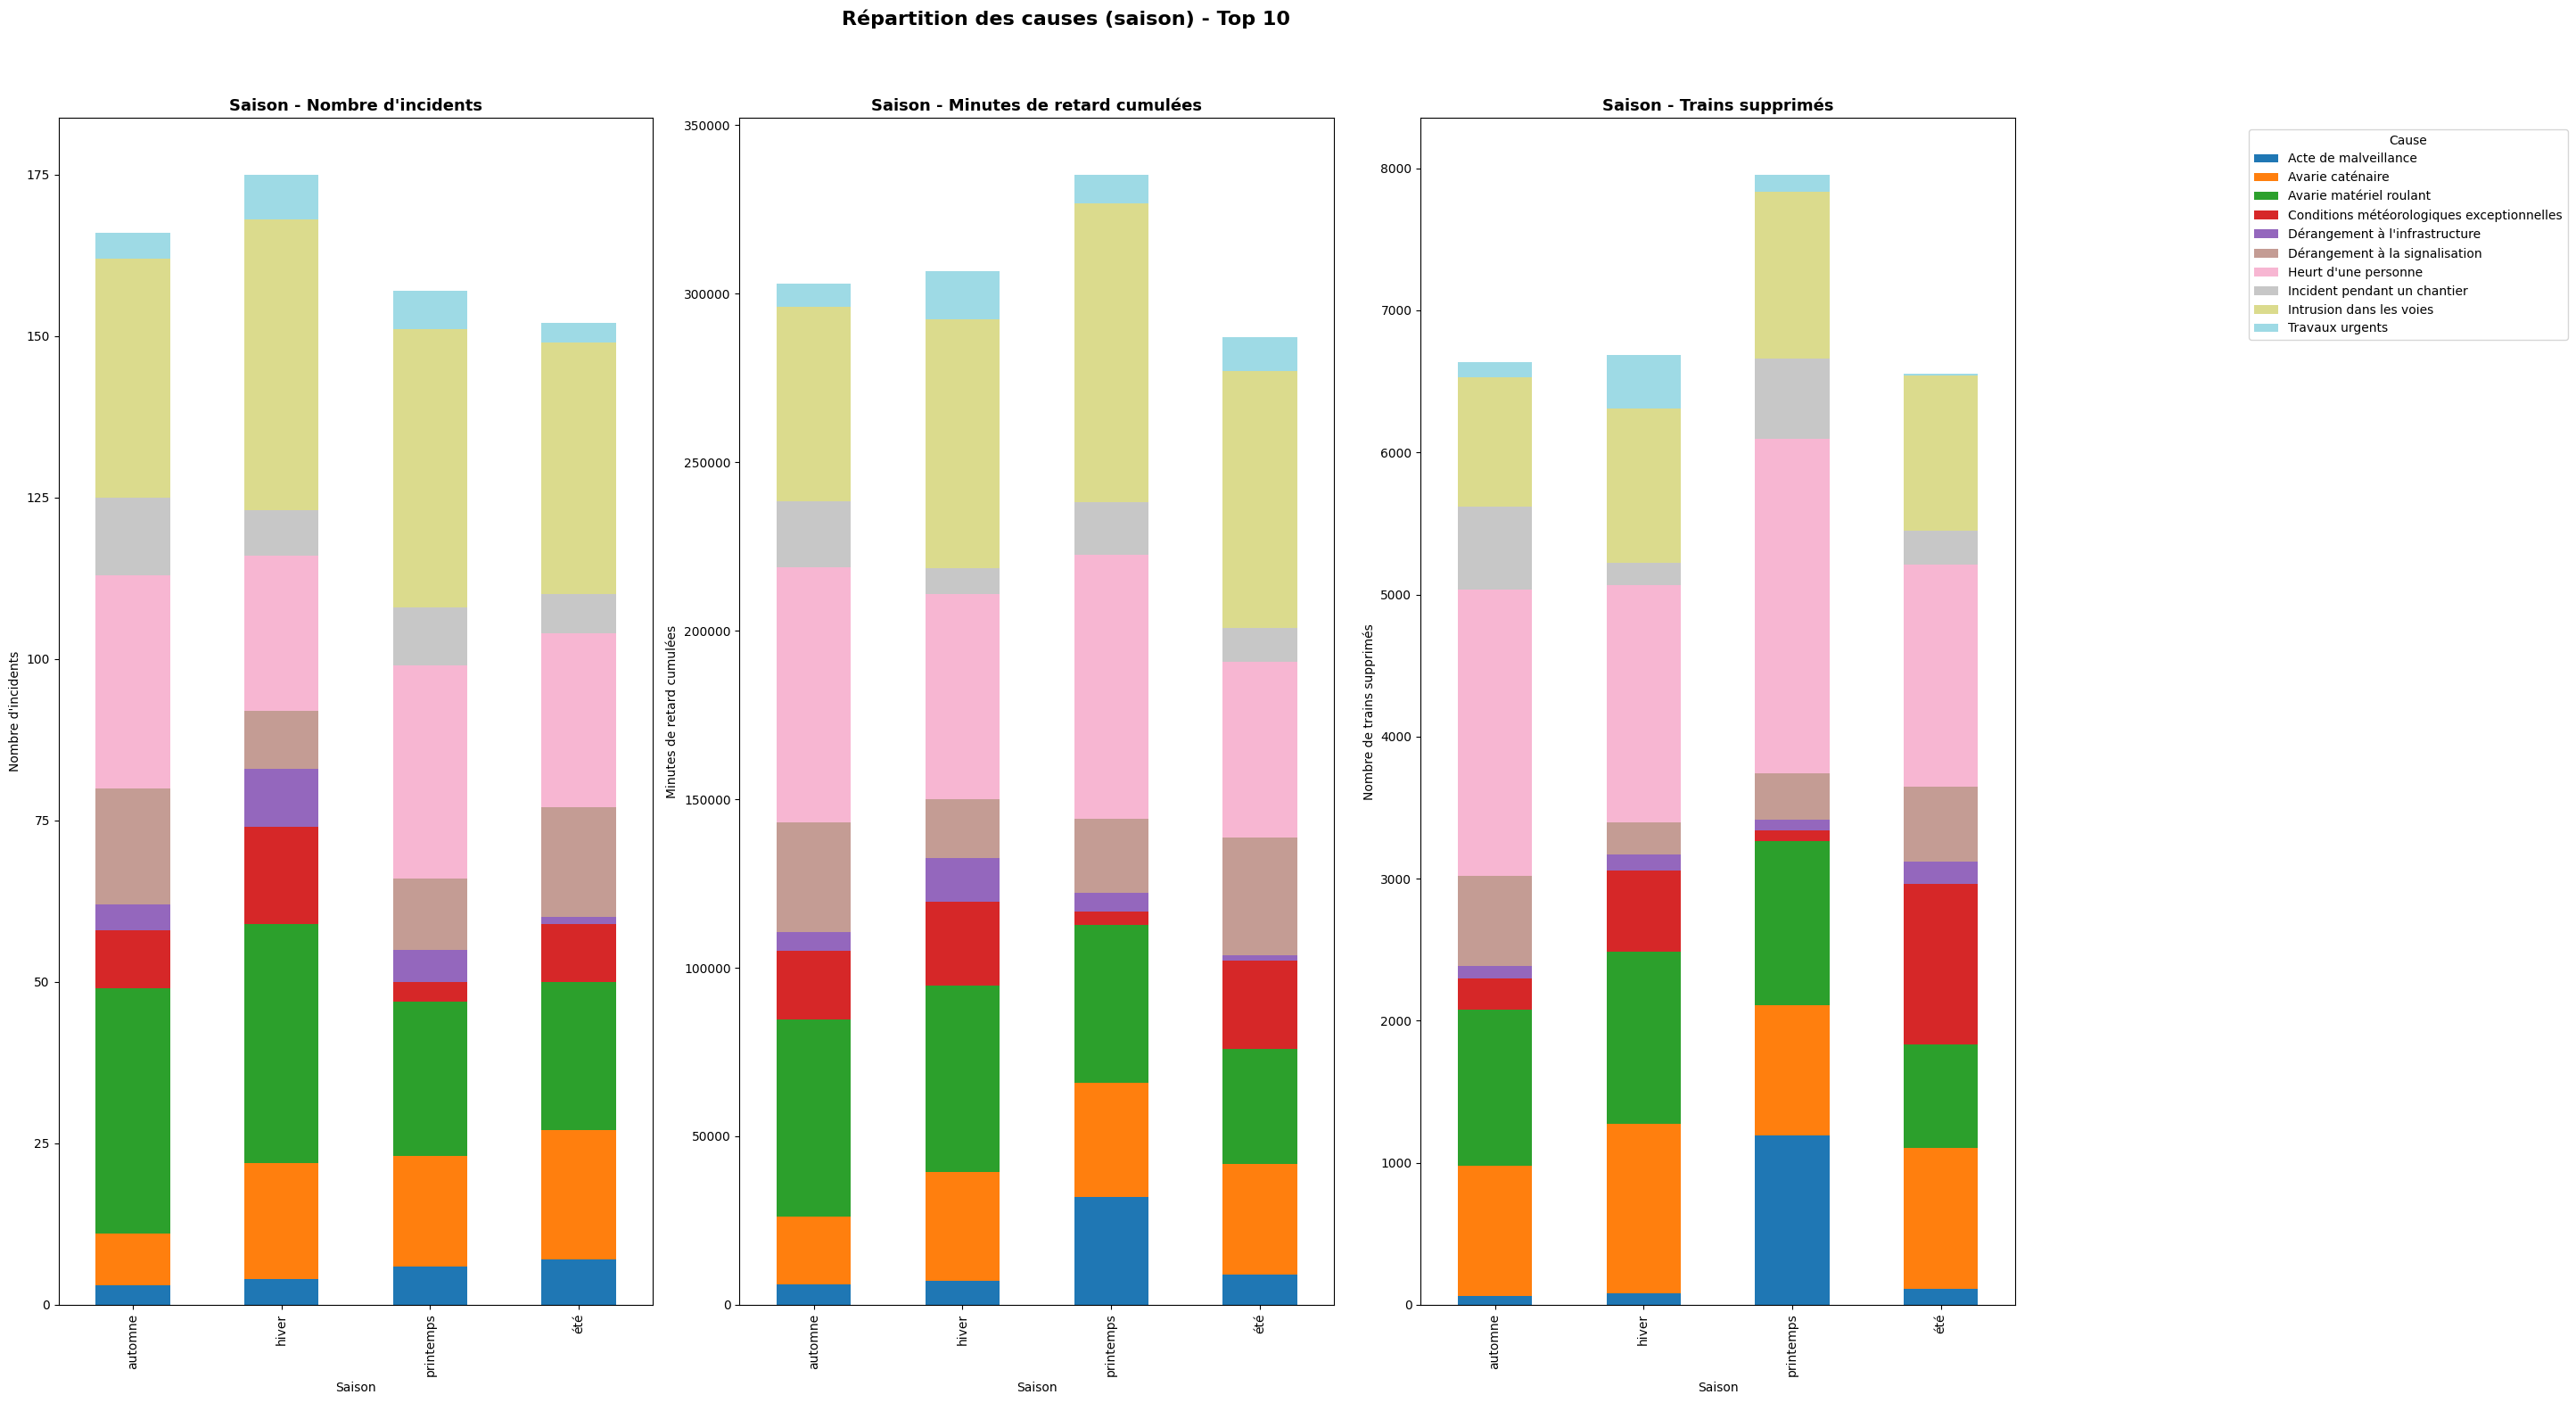

In [12]:
# Vue saisonnière
plot_cause_repartition_stacked_multi(data, "Saison", "saison")